# NLP with TensorFlow

This Notebook shows how to build a text classifier with TensorFlow.
It uses the IMDB movie review data, with labels to be 0 (negative) and 1 (positive). 
Essentially, this is a binary Sentiment Analysis problem.

The notebook has three major sections
- General: import modules and download the data.
- Part 1: use transfer learning to build a model; get the embedding layer from TensorFlow Hub.
- Part 2: build a model from scratch.



# General

## Imports

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import re
import string

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow_text as text 

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.10.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


## Download the dataset

And split it into train, evaluation, and test. 

In [4]:
%%time
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews", 
    split=('train[:70%]', 'train[70%:]', 'test'),
    as_supervised=True)

CPU times: user 122 ms, sys: 0 ns, total: 122 ms
Wall time: 120 ms


In [5]:
# Check the type of the dataset
print(type(train_data))
print(type(train_data.batch(5)))

<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


## Explore the data

Print some examples so as to understand what kinds of data pre-processing may be necessary.

In [6]:
examples, labels = next(iter(train_data.batch(5)))

for example, label in zip(examples, labels):
    print(f"- EXAMPLE: {example}")
    print(f"- LABEL: {label}")
    print()  

- EXAMPLE: b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
- LABEL: 0

- EXAMPLE: b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was

2022-10-20 20:27:04.713479: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


---
# Part 1 - Transfer Learning

## Build the Model

### Download an Embedding Layer from TensorFlow Hub

Download the embedding layer from TensorFlow Hub.
A simple model ([nnlm-en-dim50](https://tfhub.dev/google/nnlm-en-dim50/2)) is selected here so that it can be run on most machines.

Details of this model:
 - Structure: Two hidden layers.
 - Preprocessing: The module preprocesses its input by splitting on spaces.
 - Tokenization: Small fraction of the least frequent tokens and embeddings (~2.5%) are replaced by hash buckets. Each hash bucket is initialized using the remaining embedding vectors that hash to the same bucket.
 - Sentence embeddings: Word embeddings are combined into sentence embedding using the sqrtn combiner (see tf.nn.embedding_lookup_sparse).

Other candidates that may be explored on a larger machine:
- ALBERTA: https://tfhub.dev/google/collections/albert/1
- T5: https://tfhub.dev/google/collections/sentence-t5/1


In [7]:
%%time
hub_url = "https://tfhub.dev/google/nnlm-en-dim50/2"
encoder = hub.KerasLayer(hub_url, input_shape=[], dtype=tf.string, trainable=True)

CPU times: user 244 ms, sys: 167 ms, total: 411 ms
Wall time: 475 ms


### Create the Model Structure

In [8]:
model1 = tf.keras.Sequential()
model1.add(encoder)
model1.add(tf.keras.layers.Dense(20, activation='relu'))
model1.add(tf.keras.layers.Dense(1))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense (Dense)               (None, 20)                1020      
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 48,191,641
Trainable params: 48,191,641
Non-trainable params: 0
_________________________________________________________________


### Add loss function and optimizer

In [9]:
model1.compile(optimizer='adam',
               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
               metrics=['accuracy',
                       tf.keras.metrics.Precision(name="precision"),
                       tf.keras.metrics.Recall(name="recall")
                      ])

## Train the Model

Train the model for 10 epochs in mini-batches of 512 samples. This is 10 iterations over all samples in the `x_train` and `y_train` tensors. While training, monitor the model's loss and accuracy on the 10,000 samples from the validation set:

In [10]:
%%time
history1 = model1.fit(train_data.shuffle(10000).batch(512),
                      epochs=10,
                      validation_data=validation_data.batch(512),
                      verbose=1)

Epoch 1/10
35/35 [==============================] - 4s 61ms/step - loss: 0.6606 - accuracy: 0.5083 - precision: 0.9527 - recall: 0.0161 - val_loss: 0.6161 - val_accuracy: 0.5207 - val_precision: 0.9718 - val_recall: 0.0457
Epoch 2/10
35/35 [==============================] - 2s 54ms/step - loss: 0.5431 - accuracy: 0.6582 - precision: 0.9196 - recall: 0.3457 - val_loss: 0.4826 - val_accuracy: 0.7457 - val_precision: 0.9056 - val_recall: 0.5505
Epoch 3/10
35/35 [==============================] - 2s 53ms/step - loss: 0.3840 - accuracy: 0.8324 - precision: 0.9273 - recall: 0.7209 - val_loss: 0.3701 - val_accuracy: 0.8403 - val_precision: 0.9042 - val_recall: 0.7624
Epoch 4/10
35/35 [==============================] - 2s 54ms/step - loss: 0.2674 - accuracy: 0.8973 - precision: 0.9444 - recall: 0.8439 - val_loss: 0.3215 - val_accuracy: 0.8564 - val_precision: 0.9152 - val_recall: 0.7865
Epoch 5/10
35/35 [==============================] - 2s 54ms/step - loss: 0.1945 - accuracy: 0.9307 - precisi

## Plot the History

In [11]:
history1.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

In [12]:
def plot_history(history, metrics: list, title: str):

    hist = history.history
    length = len(hist[metrics[0]])
    epochs = range(1, length + 1)

    plt.figure(figsize=(6,4))
    for label in metrics:
        plt.plot(epochs, hist[label], label=label)
                                       
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()
    plt.grid()
    plt.show()


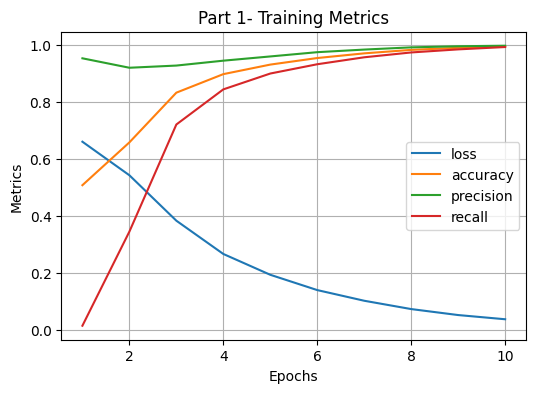

In [13]:
plot_history(history1, ['loss', 'accuracy', 'precision', 'recall'], "Part 1- Training Metrics")

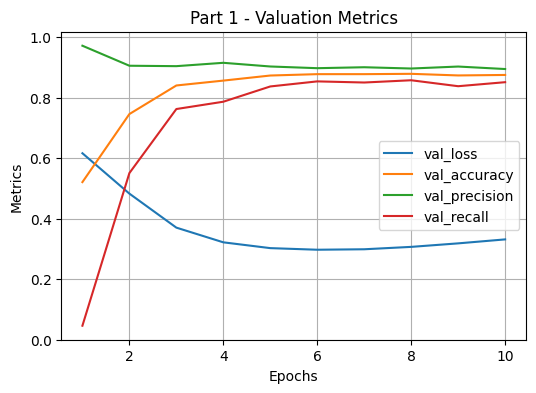

In [14]:
plot_history(history1, ['val_loss', 'val_accuracy', 'val_precision', 'val_recall'], "Part 1 - Valuation Metrics")

## Evaluate on the Test Dataset

In [18]:
results1 = model1.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model1.metrics_names, results1):
    print(f"- {name:9s} = {value:.5f}")

49/49 - 1s - loss: 0.3593 - accuracy: 0.8583 - precision: 0.8850 - recall: 0.8237 - 951ms/epoch - 19ms/step
- loss      = 0.35929
- accuracy  = 0.85832
- precision = 0.88499
- recall    = 0.82368


---
# Part 2 - Building from Scratch

## Data Pre-processing

- standardize the data.
- vectorize the text: each token will be represented by an integer.

In [19]:
max_features = 10000
sequence_length = 250

def custom_standardization(data):
    """ String processing to standardize the data."""
    # Convert to lowercase
    data = tf.strings.lower(data)
    # Remove the '<br />' HTML tags.
    data = tf.strings.regex_replace(data, '<br />', ' ')
    # Remove punctuation marks
    data = tf.strings.regex_replace(data, f'[{re.escape(string.punctuation)}]', '')
    return data

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)


# Learn the vocab from the training data.
batch_size = 32
train_text = train_data.batch(batch_size).map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [20]:
%%time
def vectorize_text(text, label):
    """Vectorize a text."""
    # Text (in the string Tensor) will be converted into a vector.
    # Therefore, needs to add a dimension at the end of the string Tensor to store the vectors.
    # Need to prepare this dimension before passing it to the vecotirze layer.
    text = tf.expand_dims(text, -1)  
    return vectorize_layer(text), label


train_ds = train_data.batch(batch_size).map(vectorize_text) 
val_ds = validation_data.batch(batch_size).map(vectorize_text)
test_ds = test_data.batch(batch_size).map(vectorize_text)

Cause: Unable to locate the source code of <function vectorize_text at 0x7fc41c7c3250>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function vectorize_text at 0x7fc41c7c3250>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function vectorize_text at 0x7fc41c7c3250>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: user 110 ms, sys: 0 ns, total: 110 ms
Wall time: 109 ms


In [21]:
# Check the data
examples, labels = next(iter(train_ds))
for example, label in zip(examples[0:2], labels[0:2]):
    print(f"- EXAMPLE: {example}")
    print(f"- EXAMPLE type = {type(example)}")
    print(f"- LABEL: {label}")
    print() 

- EXAMPLE: [  11   13   33  415  372   17   89   26 9764    8   32 1318 4219   40
  515    1  191   24   84  152   18   11  217  316   26   66  239  210
    8  469   54   66   84  111   97   21 5752   11   90  661  736   11
   17    7   33  399 9430  169 2430  414    2   88 1148  134   67  143
   52    2    1 7048   67  248   66 2799   15    1 2755    1    1 1423
 4861    3   39    1 1605   16 4219   13  154   18    4 1148  854 7663
    8    4   17   12   13 3811    5   98  145 1190   10  234  634   12
   47   24   90   38   11 7042  152   38 1318    1   49  401   10   97
 1158  846  139    9    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

## Build the Model

In [24]:
embedding_dim = 20        
# gru_units = 20

model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features + 1, embedding_dim),
    tf.keras.layers.Dropout(0.1),
    # tf.keras.layers.GRU(gru_units, return_sequences=True, name="froward_gru"),
    # tf.keras.layers.GRU(gru_units, return_sequences=False, go_backwards=True, name="backward_gru"),
    tf.keras.layers.GlobalAveragePooling1D(),
    # tf.keras.layers.Dropout(0.1),
    # tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 20)          200020    
                                                                 
 dropout (Dropout)           (None, None, 20)          0         
                                                                 
 global_average_pooling1d (G  (None, 20)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 200,041
Trainable params: 200,041
Non-trainable params: 0
_________________________________________________________________


In [25]:
model2.compile(optimizer='adam',
               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
               metrics=['accuracy',
                        tf.keras.metrics.Precision(name="precision"),
                        tf.keras.metrics.Recall(name="recall")
                       ])

## Train the Model

In [26]:
%%time
epochs = 10
history2 = model2.fit(train_ds,
                      validation_data=val_ds,
                      epochs=epochs,
                      verbose=1
                     )

Epoch 1/10
547/547 [==============================] - 6s 10ms/step - loss: 0.6610 - accuracy: 0.5083 - precision: 0.9527 - recall: 0.0161 - val_loss: 0.6069 - val_accuracy: 0.5692 - val_precision: 0.9388 - val_recall: 0.1510
Epoch 2/10
547/547 [==============================] - 5s 10ms/step - loss: 0.5355 - accuracy: 0.6811 - precision: 0.9224 - recall: 0.3946 - val_loss: 0.4851 - val_accuracy: 0.7596 - val_precision: 0.9173 - val_recall: 0.5723
Epoch 3/10
547/547 [==============================] - 5s 10ms/step - loss: 0.4264 - accuracy: 0.8069 - precision: 0.9258 - recall: 0.6667 - val_loss: 0.4096 - val_accuracy: 0.8189 - val_precision: 0.9171 - val_recall: 0.7026
Epoch 4/10
547/547 [==============================] - 5s 10ms/step - loss: 0.3590 - accuracy: 0.8490 - precision: 0.9288 - recall: 0.7556 - val_loss: 0.3675 - val_accuracy: 0.8407 - val_precision: 0.9123 - val_recall: 0.7549
Epoch 5/10
547/547 [==============================] - 5s 9ms/step - loss: 0.3160 - accuracy: 0.8706 

## Plot the History

In [29]:
history2.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

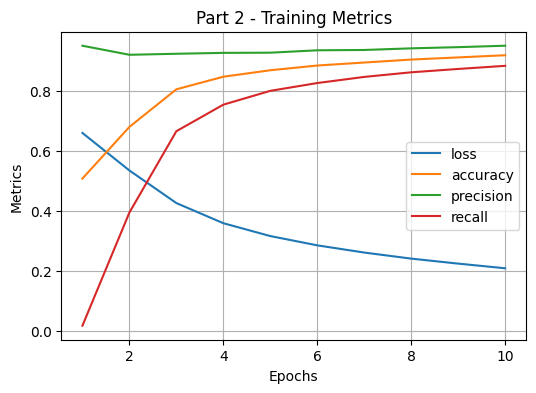

In [31]:
plot_history(history2, ['loss', 'accuracy', 'precision', 'recall'], "Part 2 - Training Metrics")

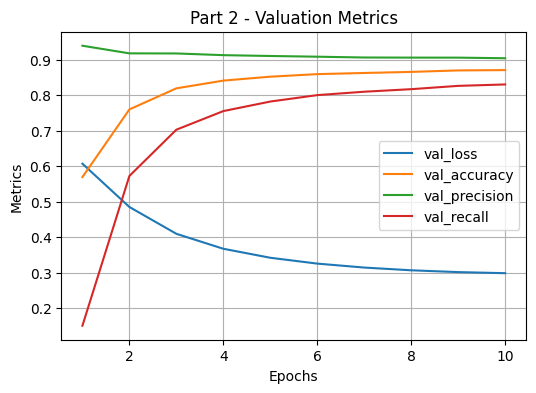

In [32]:
plot_history(history2, ['val_loss', 'val_accuracy', 'val_precision', 'val_recall'], "Part 2 - Valuation Metrics")

## Evaluate on the Test Dataset

In [34]:
# Part 2 results
results2 = model2.evaluate(test_ds, verbose=2)

for name, value in zip(model2.metrics_names, results2):
    print(f"- {name:9s} = {value:.5f}")

782/782 - 3s - loss: 0.3120 - accuracy: 0.8599 - precision: 0.9043 - recall: 0.8050 - 3s/epoch - 4ms/step
- loss      = 0.31202
- accuracy  = 0.85988
- precision = 0.90429
- recall    = 0.80496


In [35]:
# Re-print Part 1 results
results1 = model1.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model1.metrics_names, results1):
    print(f"- {name:9s} = {value:.5f}")

49/49 - 1s - loss: 0.3593 - accuracy: 0.8583 - precision: 0.8850 - recall: 0.8237 - 956ms/epoch - 20ms/step
- loss      = 0.35929
- accuracy  = 0.85832
- precision = 0.88499
- recall    = 0.82368


---
# Conclusion

It is interesting to see that both models have similar performance.
It is probably because both are simple and small models. 
There are room for improvements.

For the pre-build model.
  - Use a Transformer-based embedding layer. They probably do a better job on
    tokenization and they can handle contexts better.
  - Look for a pre-build sentiment analysis models and possibly go beyond TensoFlow Hub (e.g. try Hugging face).

For the custom model.
  - Use a sentiment-aware tokenizer.
  - Add negation marking.
  - Introduce layers that can handle context (e.g. Bi-LSTM).
  - User larger embedding dimension.
  - Add a Dense neural network.
  
